/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarn

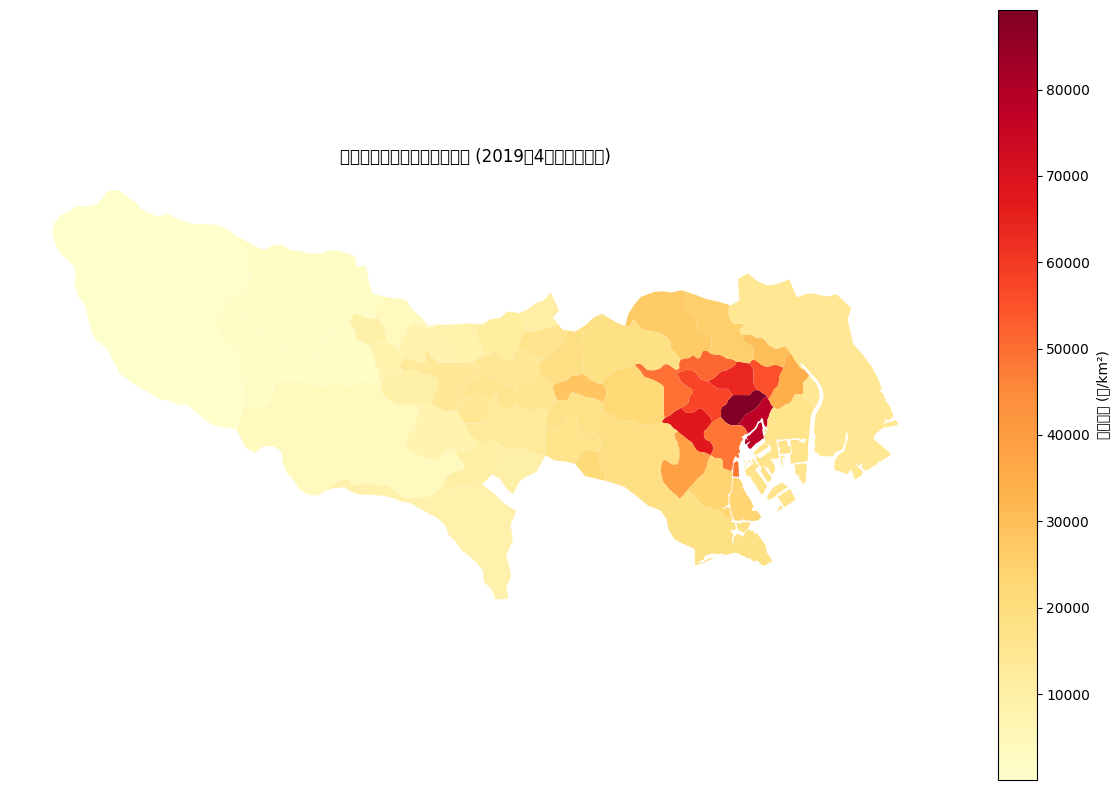


人口密度が最も高い5市区町村:
       city   pop_density   area_km2  population
0   Chiyoda  89219.196590   9.995069    891752.0
1      Chūō  78025.852725   9.005989    702700.0
2   Shibuya  67844.753509  14.035455    952232.0
3    Bunkyō  64280.027421  11.539556    741763.0
4  Shinjuku  57842.042527  15.938061    921890.0


In [1]:
# F3. 東京都の2019年4月（休日・昼間）の市区町村の人口密度 (人/km^2)を地図で示せ.

import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# データベース接続
engine = create_engine('postgresql://postgres:postgres@db:5432/gisdb')

# 2019年4月の人口密度を計算するSQLクエリ
query = """
WITH pop_2019 AS (
    SELECT a.name_2, 
           SUM(p.population) as total_pop,
           ST_Area(a.geom::geography)/1000000 as area_km2
    FROM adm2 a
    JOIN pop201904 p ON ST_Intersects(a.geom, p.geom)
    WHERE a.name_1 = 'Tokyo'
    GROUP BY a.name_2, a.geom
)
SELECT 
    a.name_2 as city,
    a.geom,
    COALESCE(p.total_pop, 0) as population,
    p.area_km2,
    CASE 
        WHEN p.area_km2 > 0 THEN COALESCE(p.total_pop, 0) / p.area_km2 
        ELSE 0 
    END as pop_density
FROM adm2 a
LEFT JOIN pop_2019 p ON a.name_2 = p.name_2
WHERE a.name_1 = 'Tokyo'
ORDER BY pop_density DESC;
"""

# クエリを実行してGeoDataFrameを作成
gdf = gpd.read_postgis(query, engine, geom_col='geom')

# 地図の作成
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='pop_density', 
        ax=ax,
        legend=True,
        legend_kwds={'label': '人口密度 (人/km²)'},
        cmap='YlOrRd',
        missing_kwds={'color': 'lightgrey'})

# タイトルを追加
plt.title('東京都の市区町村別人口密度 (2019年4月・休日昼間)')

# 軸ラベルを非表示
ax.axis('off')

plt.show()

# 人口密度の上位5市区町村を表示
print("\n人口密度が最も高い5市区町村:")
print(gdf.nlargest(5, 'pop_density')[['city', 'pop_density', 'area_km2', 'population']])